## Import libs and data

In [26]:
import pandas as pd
import re
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm, tqdm_notebook, trange
tqdm.pandas()
from collections import Counter
import pickle
import squarify
import collections

In [2]:
df_user_x_cat = pd.read_csv('../src/pantip_user_cat.csv')

In [3]:
df_user_x_cat.head()

,user_id,category,post_date
0,4179868,travel,2018-12-06 21:31:06
1,2897151,travel,2018-12-06 21:19:04
2,772076,travel,2018-12-06 20:52:07
3,4977690,travel,2018-12-06 20:24:25
4,2239672,travel,2018-12-06 20:03:01


In [4]:
df_user_x_cat.category.nunique()

5915

In [5]:
# select top 500 most popular categories
cat_counter = Counter(df_user_x_cat.category.values)

## create tags set and prepare dataframe

In [7]:
# create list of tags
tag_list=[]
for text in df_user_x_cat.category:
    tag_list.append(text.split(', '))

all_tags = []
for tl in tag_list:
    for tag in tl:
        if not tag in all_tags:
            all_tags.append(tag)

In [8]:
all_tags

['travel',
 'auto',
 'pantip_food',
 'pantip_cartoon',
 'pantip_chalermthai',
 'pantip_chalermkrung',
 'pantip_korea',
 'pantip_gadget',
 'pantip_siliconvalley',
 'pantip_family',
 'pantip_rajdumnern',
 'pantip_social',
 'pantip_klaibann',
 'pantip_home',
 'pantip_tvshow',
 'pantip_region',
 'pantip_mbk',
 'pantip_supachalasai',
 'pantip_lumpini',
 'pantip_sinthorn',
 'pantip_wahkor',
 'pantip_library',
 'pantip_siam',
 'pantip_beauty',
 'pantip_bangrak']

In [6]:
df_tags = pd.DataFrame(np.zeros((len(tag_list),len(all_tags))),columns=all_tags)

for i in tqdm_notebook(range(len(tag_list))):
    for tag in tag_list[i]:
        df_tags.loc[i,tag] = 1

df_tags['user_id'] = df_user_x_cat.user_id.values

df_tags.to_csv('../tmp/df_tags.csv',index=False)

In [9]:
df_tags = pd.read_csv('../tmp/df_tags.csv')

In [10]:
df_user_segment = df_tags.groupby('user_id').sum()
df_user_segment.head()

,travel,auto,pantip_food,pantip_cartoon,pantip_chalermthai,pantip_chalermkrung,pantip_korea,pantip_gadget,pantip_siliconvalley,pantip_family,pantip_rajdumnern,pantip_social,pantip_klaibann,pantip_home,pantip_tvshow,pantip_region,pantip_mbk,pantip_supachalasai,pantip_lumpini,pantip_sinthorn,pantip_wahkor,pantip_library,pantip_siam,pantip_beauty,pantip_bangrak
user_id,,,,,,,,,,,,,,,,,,,,,,,,,
4,3.0,0.0,4.0,3.0,2.0,0.0,0.0,0.0,1.0,5.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
13,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
101,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123,1.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,92.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,2.0,0.0


In [11]:
df_user_segment = df_user_segment.div(df_user_segment.sum(axis=1), axis=0)

## Performing segmentation

In [12]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
user_segment_sc = sc.fit_transform(df_user_segment)

In [13]:
from sklearn.cluster import KMeans

k_model = KMeans(n_clusters=7)

segment = k_model.fit_predict(user_segment_sc)

df_user_segment['segment_id'] = segment

# summary statistic by segment
df_segment = df_user_segment.groupby('segment_id')[all_tags].mean()

df_user_segment.reset_index(inplace=True)

df_segment = df_segment.join(df_user_segment.groupby('segment_id')['user_id'].count()).rename({'user_id':'total_user'},axis=1)

In [14]:
df_segment

,travel,auto,pantip_food,pantip_cartoon,pantip_chalermthai,pantip_chalermkrung,pantip_korea,pantip_gadget,pantip_siliconvalley,pantip_family,pantip_rajdumnern,pantip_social,pantip_klaibann,pantip_home,pantip_tvshow,pantip_region,pantip_mbk,pantip_supachalasai,pantip_lumpini,pantip_sinthorn,pantip_wahkor,pantip_library,pantip_siam,pantip_beauty,pantip_bangrak,total_user
segment_id,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.005148,0.009571,0.003195,0.010459,0.005067,0.004099,0.000550,0.002817,0.806739,0.002687,0.000449,0.014853,0.002311,0.010965,0.001034,0.004612,0.062154,0.002959,0.009105,0.006317,0.007138,0.008015,0.018595,0.000485,0.000675,82262
1,0.003953,0.005108,0.004194,0.004754,0.003682,0.006532,0.002029,0.000248,0.009124,0.016148,0.000520,0.047193,0.010274,0.003161,0.002540,0.005057,0.011040,0.002468,0.025597,0.004661,0.007743,0.160256,0.646936,0.000567,0.016218,229201
2,0.006513,0.004714,0.003174,0.010809,0.015933,0.822131,0.015354,0.000370,0.018164,0.002859,0.000209,0.007163,0.003120,0.003064,0.007610,0.005284,0.013873,0.003038,0.009692,0.002856,0.002306,0.010445,0.028346,0.001389,0.001583,34710
3,0.016741,0.094737,0.043859,0.033182,0.037739,0.011636,0.011487,0.003353,0.029857,0.012579,0.003333,0.111576,0.028897,0.067390,0.007351,0.008134,0.170984,0.041819,0.115541,0.076643,0.024376,0.011714,0.027278,0.004778,0.005016,527854
4,0.006581,0.012067,0.003536,0.002041,0.005837,0.003530,0.000051,0.000042,0.009045,0.002895,0.852277,0.019804,0.001429,0.006168,0.001800,0.005239,0.012972,0.012192,0.005261,0.017464,0.007542,0.007652,0.004289,0.000115,0.000171,11844
5,0.340031,0.036642,0.016490,0.002199,0.004416,0.004163,0.001833,0.000393,0.007777,0.225615,0.000785,0.030371,0.044718,0.013109,0.002126,0.154495,0.015002,0.003589,0.027383,0.008606,0.002326,0.006636,0.027478,0.007490,0.016326,161104
6,0.007270,0.004397,0.005499,0.005655,0.041750,0.045062,0.012358,0.000174,0.009902,0.004457,0.001405,0.011723,0.003008,0.003987,0.765824,0.003035,0.013240,0.011200,0.009938,0.004024,0.002207,0.009290,0.019968,0.004246,0.000382,17452


In [15]:
df_user_segment.to_csv('../out/df_segment.csv',index=False)
df_segment.to_csv('../out/df_segment.csv')

In [16]:
df_segment = pd.read_csv('../out/df_segment.csv')
df_segment.set_index('segment_id',inplace=True)

In [17]:
segment_lst = df_segment.columns[:-1]

# find top 3 traits for each segment
seg_character = []
for seg_id in df_segment.index:
    seg_dict = dict()
    top_3 = np.argsort(df_segment.loc[seg_id].values[:-1])[-3:]
    for i in range(2, -1,-1):
        seg_dict[segment_lst[top_3[i]]] = df_segment.loc[seg_id].values[top_3[i]]
    seg_character.append(seg_dict)

In [18]:
seg_character

[{'pantip_siliconvalley': 0.8067391282496326,
  'pantip_mbk': 0.062153983528418874,
  'pantip_siam': 0.018595198311176037},
 {'pantip_siam': 0.6469357292754989,
  'pantip_library': 0.16025630124700205,
  'pantip_social': 0.047192875283734614},
 {'pantip_chalermkrung': 0.8221311761483547,
  'pantip_siam': 0.028346160281186143,
  'pantip_siliconvalley': 0.018163744938812138},
 {'pantip_mbk': 0.1709838001314808,
  'pantip_lumpini': 0.11554142502375807,
  'pantip_social': 0.11157613999126947},
 {'pantip_rajdumnern': 0.8522773507081759,
  'pantip_social': 0.019804463366629648,
  'pantip_sinthorn': 0.017464465037337586},
 {'travel': 0.3400313943216099,
  'pantip_family': 0.2256150948508757,
  'pantip_region': 0.15449534571533638},
 {'pantip_tvshow': 0.7658243260397096,
  'pantip_chalermkrung': 0.045062315126448316,
  'pantip_chalermthai': 0.04174967327942662}]

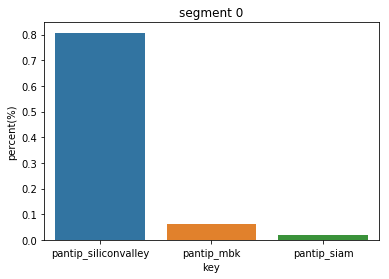

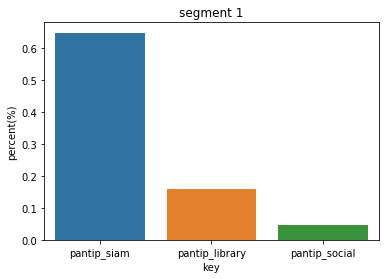

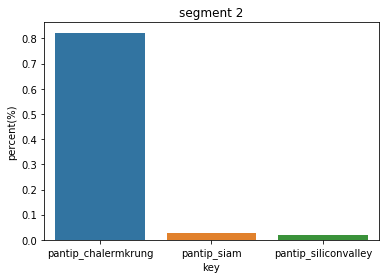

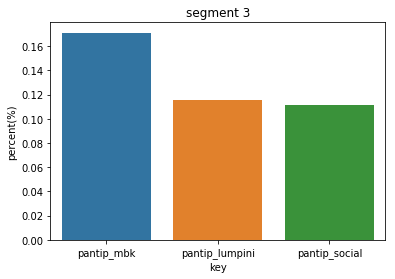

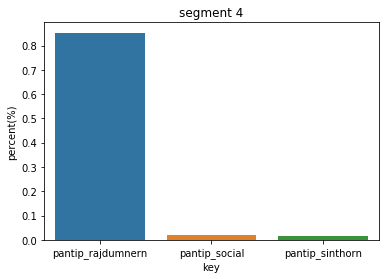

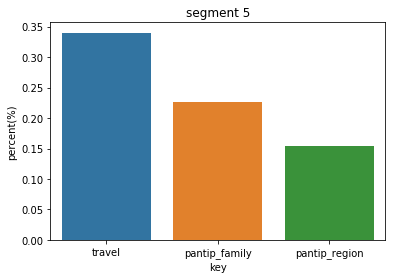

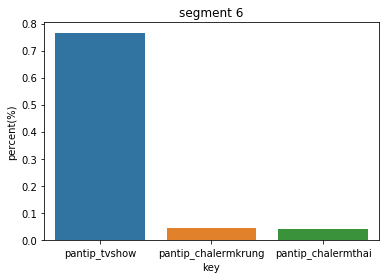

In [36]:
# visualize segment character
for i in range(7):
    df_plot = pd.DataFrame({'key':list(seg_character[i].keys()),'percent(%)':list(seg_character[i].values())})
    sns.barplot(x='key',y='percent(%)',data=df_plot,).set_title(f'segment {i}')
    plt.show()

## Summarize segmentation per keyword

In [19]:
# create user-segment mapper
user_x_segment = dict()
for i in range(len(df_user_segment)):
    user_x_segment[df_user_segment.iloc[i]['user_id']] = df_user_segment.iloc[i]['segment_id']

In [20]:
with open('../out/user_x_segment.pkl', 'wb') as fp:
    pickle.dump(user_x_segment,fp)

## check point

In [21]:
with open('../out/user_x_segment.pkl', 'rb') as fp:
    user_x_segment = pickle.load(fp)

In [22]:
df_post = pd.read_csv('../out/aviation/df_post.csv')
with open('../out/aviation/tokens_post.txt', 'rb') as fp:   #Un-pickling
    tokens_post = pickle.load(fp)

In [24]:
df_post['user_id'] = df_post['user_id'].astype(int)

total unique user: 1193


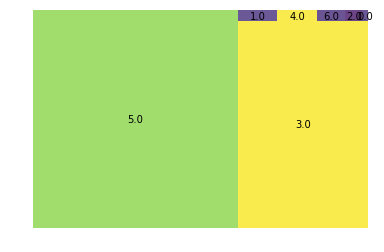

In [25]:
# visualize user segment per keyword
kws = ['การบินไทย','tg']

idxs=[]
for i,tkn in enumerate(tokens_post):
    for kw in kws:
        if kw in tkn:
            idxs.append(i)
            break
            
df_temp = df_post.iloc[idxs]

unique_user = df_temp.user_id.unique()

print('total unique user:',len(unique_user))

corr_seg = []
for user in unique_user:
    corr_seg.append(user_x_segment[user])

df_prod_seg = pd.DataFrame({'user_id':unique_user,'segment_id':corr_seg})

squarify.plot(sizes=df_prod_seg.segment_id.value_counts().values, label=df_prod_seg.segment_id.value_counts().index, alpha=.8 )
_=plt.axis('off')